**PyOD** library, described as "a comprehensive
and scalable Python toolkit for detecting outlying objects in multivariate data."

In [49]:
!pip install pyod --quiet

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 3]

In [51]:
file = Path("/content/drive/MyDrive/Data/TimeSeries/nyc_taxi.csv")
nyc_taxi = pd.read_csv(file, index_col='timestamp', parse_dates=True)
nyc_taxi.index.freq = '30T'
nyc_taxi.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


In [52]:
nyc_taxi.index.min(),nyc_taxi.index.max()

(Timestamp('2014-07-01 00:00:00', freq='30T'),
 Timestamp('2015-01-31 23:30:00', freq='30T'))

In [53]:
nyc_taxi.shape

(10320, 1)

In [54]:
nyc_taxi.describe()

,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


<Axes: xlabel='timestamp'>

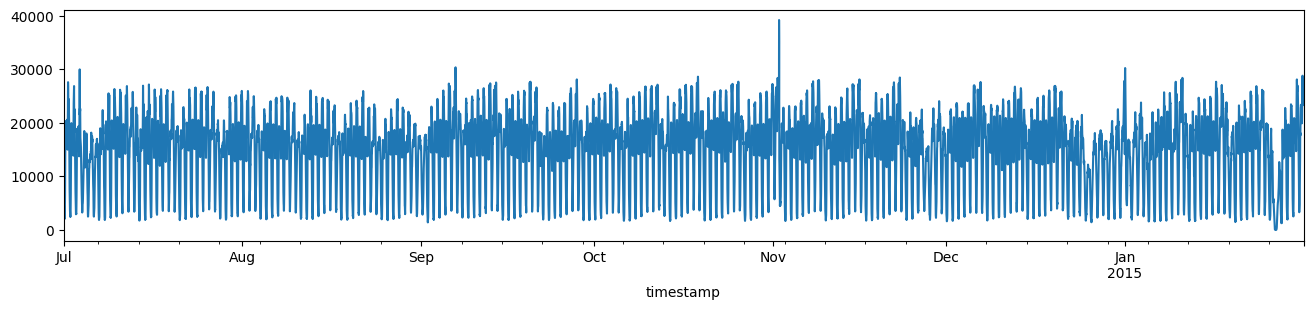

In [55]:
nyc_taxi.value.plot()

In [56]:
def plot_outliers(outliers, data, method='KNN',
                 halignment = 'right',
                 valignment = 'top',
                 labels=False,
                 name=None):

    ax = data.plot(alpha=0.6)

    if labels:
        for i in outliers['value'].items():
            plt.plot(i[0], i[1], 'v', markersize=8, markerfacecolor='none', markeredgecolor='k')
            plt.text(i[0], i[1]-(i[1]*0.04), f'{i[0].strftime("%m/%d")}',
                         horizontalalignment=halignment,
                         verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax, style='rX', markersize=9)

    plt.title(f'NYC Taxi - {method}')
    plt.xlabel('date'); plt.ylabel('Number of passengers')
    plt.legend(['nyc taxi','outliers'])
    # if name:
    #     plt.savefig(f'../../../Packt-Time-Series-Cookbook/Chapters/Ch14/images/{name}.png', bbox_inches='tight', dpi=600)
    plt.show()

Ground truth labels: known outlier dates

In [57]:
nyc_dates = [
"2014-11-01",
"2014-11-27",
"2014-12-25",
"2015-01-01",
"2015-01-27"]


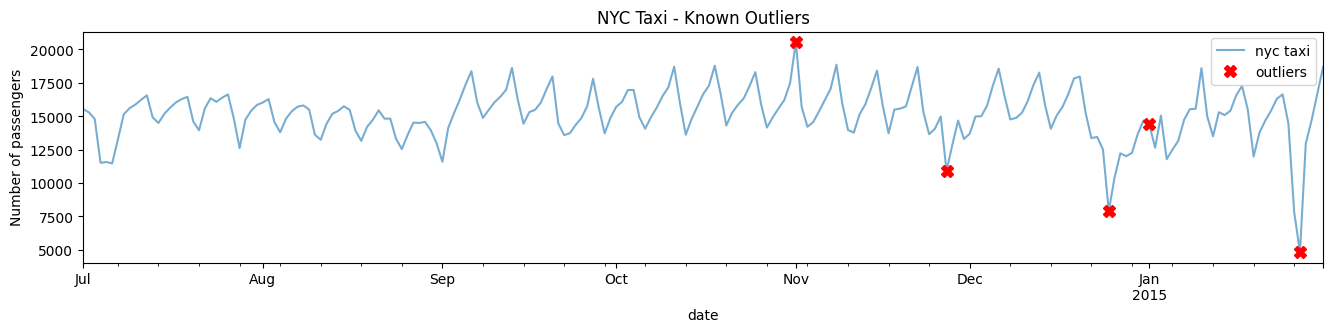

In [58]:
tx = nyc_taxi.resample('D').mean()
known_outliers = tx.loc[nyc_dates]
plot_outliers(known_outliers, tx, 'Known Outliers')

##KNN for outlier detection

Since we do not know
the outliers (labels) in advance, KNN is used in an unsupervised learning manner. In
this scenario, the algorithm finds the closest K nearest neighbors for every data point
and measures the average distance. The points with the most significant distance from
the population will be considered outliers, and more specifically, they are considered
**global outliers**. In this case, the distance becomes the score to determine which points are
outliers among the population, and hence **KNN is a proximity-based algorithm**.

In [59]:
from pyod.models.knn import KNN

Parameters that control the alogirithm behavior


1.   Contamination: value representing the
dataset's fraction of outliers. For example, a contamination value of 0.1
indicates that you expect 10% of the data to be outliers. For example, if you suspect the proportion of outliers in your data at 3%, then
you can use that as the contamination value. You could experiment with different
contamination values, inspect the results, and determine how to adjust the
contamination level.




In [60]:
knn = KNN(contamination=0.03, method='mean', n_neighbors=5,metric='euclidean')
knn.fit(tx)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='euclidean', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [61]:
#The predict method will generate binary labels, either 1 or 0, for each data point.
predicted = pd.Series(knn.predict(tx),index=tx.index)
print('Number of outliers = ', predicted.sum())


Number of outliers =  6


In [62]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index]
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


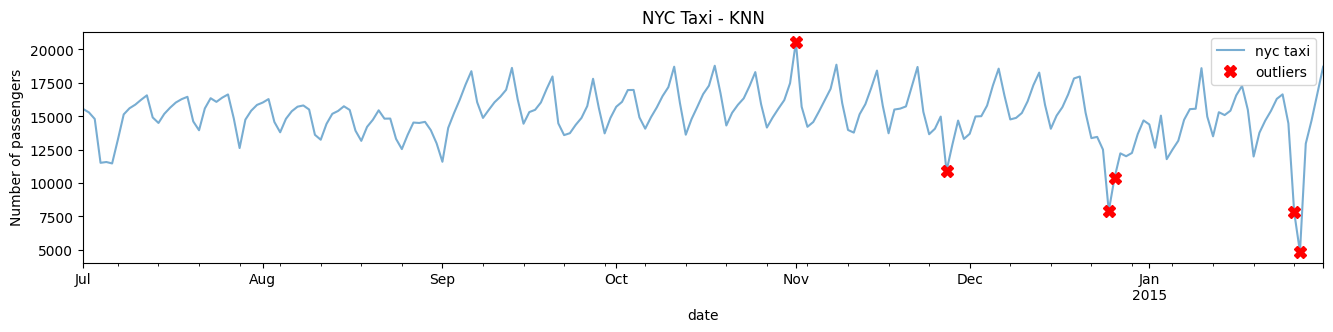

In [63]:
plot_outliers(outliers, tx, 'KNN')

Decision scores: These scores typically represent some measure of how unusual or anomalous each data point is, according to the KNN algorithm

In [64]:
knn_scores = knn.decision_scores_
knn_scores[:10]

array([ 26.52083333,  26.79166667,  20.36666667, 186.20833333,
       162.        , 224.20833333,  59.58333333,  45.725     ,
        21.7625    ,  22.7       ])

Overall, KNN does a good
job of capturing global outliers, but those far from the surrounding points may not do well
with identifying local outliers.

This is where the Local Outlier Factor (LOF) comes in to solve this limitation. Instead of using the distance
between neighboring points, it uses density as a basis for scoring data points and detecting
outliers. The LOF is considered a density-based algorithm. \\
The idea behind the LOF is that outliers will be further from other data points and more isolated, and thus will be in low-density regions

In [66]:
from pyod.models.lof import LOF

In [67]:
lof = LOF(contamination=0.03, n_neighbors=5)
lof.fit(tx)

LOF(algorithm='auto', contamination=0.03, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=5, novelty=True, p=2)

In [68]:
predicted = pd.Series(lof.predict(tx),
index=tx.index)
print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [69]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index]
outliers

,value
timestamp,
2014-10-31,17473.354167
2014-11-01,20553.500000
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


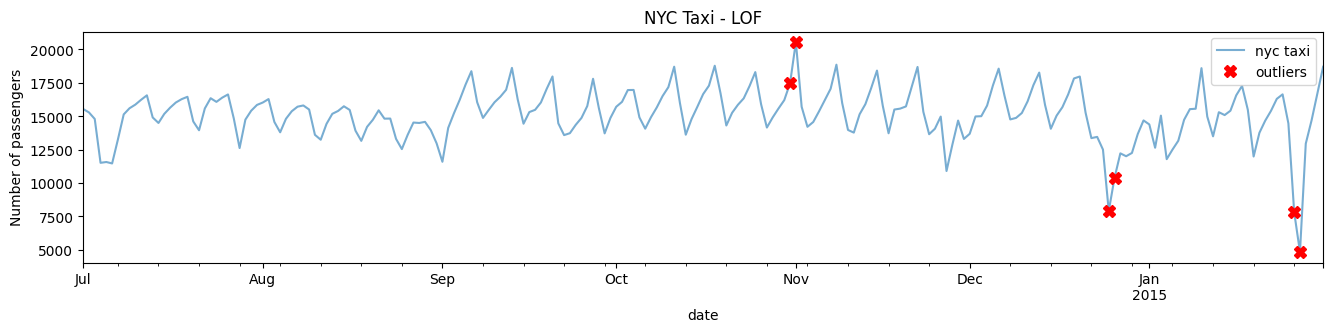

In [70]:
plot_outliers(outliers, tx, 'LOF')

##Outlier detection with Isolation Forests

iForest, an ensemble learning method, is the unsupervised learning approach to
Random Forests. The iForest algorithm isolates anomalies by randomly partitioning
(splitting) a dataset into multiple partitions. This is performed recursively until all data
points belong to a partition. The number of partitions required to isolate an anomaly is
typically smaller than the number of partitions needed to isolate a regular point.
The idea is that an anomaly data point is further from other points and thus easier
to separate (isolate).

In [71]:
from pyod.models.iforest import IForest

In [73]:
iforest = IForest(contamination=0.03,n_estimators=100,random_state=0)
#Set the random_state to a value to make sure that we get the same result when we rerun the algo
iforest.fit(tx)

IForest(behaviour='old', bootstrap=False, contamination=0.03,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=0, verbose=0)

In [74]:
predicted = pd.Series(iforest.predict(tx),
index=tx.index)
print('Number of outliers = ', predicted.sum())

Number of outliers =  7


In [75]:
outliers = predicted[predicted == 1]
outliers = tx.loc[outliers.index]
outliers

,value
timestamp,
2014-11-01,20553.500000
2014-11-08,18857.333333
2014-11-27,10899.666667
2014-12-25,7902.125000
2014-12-26,10397.958333
2015-01-26,7818.979167
2015-01-27,4834.541667


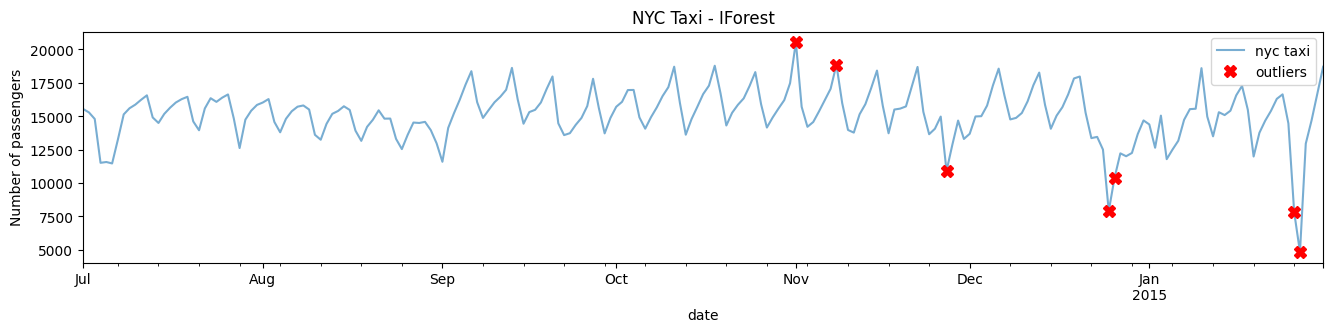

In [76]:
plot_outliers(outliers, tx, 'IForest')